Using sources:

https://huggingface.co/blog/fine-tune-vit

## Set up drive and libraries

In [1]:
# from google.colab import drive
import numpy as np
from datasets import load_dataset
import sys
import torch
# import timm
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
from src.datasets.imagenet1k import make_imagenet1k as asdf
from src.transforms import make_transforms
from src import helper
from src.models import vision_transformer
from datasets import Dataset, DatasetDict


/home/tomtom/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [56]:
transform = make_transforms(
    crop_size=224,
    crop_scale=[0.3, 1.0],
    gaussian_blur=False,
    horizontal_flip=False,
    color_distortion=False,
    color_jitter=0.0)

transform_with_resize = transforms.Compose([
  transforms.Resize((224, 224)),
  transform
  ])

INFO:root:making imagenet data transforms


Get CIFAR-10

In [57]:
cifar10 = load_dataset("cifar10")

train_val_split = cifar10['train'].train_test_split(test_size=0.3, seed=1)

train_set = train_val_split['train']
val_set = train_val_split['test']
test_set = cifar10['test']

In [4]:
CHECKPOINT_FILE = './checkpoint/IN1K-vit.h.14-300e.pth.tar'

checkpoint = torch.load(CHECKPOINT_FILE, map_location=torch.device('cpu'))



/tmp/ipykernel_8128/3593421671.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_FILE, map_location=torch.device('cpu'))


In [5]:

target_encoder_weights = checkpoint['target_encoder']
del checkpoint
import gc
gc.collect()  # Force garbage collection to free up memory


9

In [6]:
print(target_encoder_weights.keys())

odict_keys(['module.pos_embed', 'module.patch_embed.proj.weight', 'module.patch_embed.proj.bias', 'module.blocks.0.norm1.weight', 'module.blocks.0.norm1.bias', 'module.blocks.0.attn.qkv.weight', 'module.blocks.0.attn.qkv.bias', 'module.blocks.0.attn.proj.weight', 'module.blocks.0.attn.proj.bias', 'module.blocks.0.norm2.weight', 'module.blocks.0.norm2.bias', 'module.blocks.0.mlp.fc1.weight', 'module.blocks.0.mlp.fc1.bias', 'module.blocks.0.mlp.fc2.weight', 'module.blocks.0.mlp.fc2.bias', 'module.blocks.1.norm1.weight', 'module.blocks.1.norm1.bias', 'module.blocks.1.attn.qkv.weight', 'module.blocks.1.attn.qkv.bias', 'module.blocks.1.attn.proj.weight', 'module.blocks.1.attn.proj.bias', 'module.blocks.1.norm2.weight', 'module.blocks.1.norm2.bias', 'module.blocks.1.mlp.fc1.weight', 'module.blocks.1.mlp.fc1.bias', 'module.blocks.1.mlp.fc2.weight', 'module.blocks.1.mlp.fc2.bias', 'module.blocks.2.norm1.weight', 'module.blocks.2.norm1.bias', 'module.blocks.2.attn.qkv.weight', 'module.blocks.2.

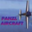

In [63]:
cifar_ex = cifar10['train'][400]
cifar_image = cifar_ex['img']
cifar_image

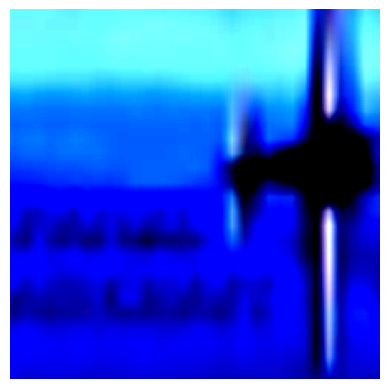

In [64]:
input_tensor = transform_with_resize(cifar_image)#.unsqueeze(0)  # Add batch dimension


# Convert tensor to numpy for display (and move channel dimension)
image_for_visualization = input_tensor.permute(1, 2, 0).numpy()

# Display the image using matplotlib
plt.imshow(image_for_visualization)
plt.axis('off')  # Hide axes
plt.show()

In [9]:
import copy
d = torch.device('cuda:0')
torch.cuda.set_device(d)
encoder, predictor = helper.init_model(
    device = d,
    patch_size=14,
    crop_size=224,
    pred_depth=12,
    pred_emb_dim=384,
    model_name='vit_huge')
target_encoder = copy.deepcopy(encoder)

INFO:root:VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
  )
  (blocks): ModuleList(
    (0-31): 32 x Block(
      (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1280, out_features=3840, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1280, out_features=1280, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
)


In [10]:
target_encoder_weights = {k.replace('module.', ''): v for k, v in target_encoder_weights.items()}
target_encoder.eval()
for p in target_encoder.parameters():
    p.requires_grad = False

msg = target_encoder.load_state_dict(target_encoder_weights)

In [48]:
class EncodeClassifyNet(nn.Module):
    def __init__(self, target_encoder, transform):
        super().__init__()

        self.model = nn.Sequential(
            target_encoder,
            nn.AvgPool2d(kernel_size=4, stride=4),
            nn.Flatten(),
            nn.Linear(320 * 64, 10)
        )

    def forward(self, x):
        return self.model(x)

In [49]:
NN = EncodeClassifyNet(target_encoder, transform)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NN = NN.to(device)



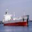

In [58]:
train_set['img'][0]


In [66]:
set = train_set[0:10]
imgs = set['img']
print(imgs)

input_tensor = transform_with_resize(torch.stack(imgs, dim=0))
print(input_tensor)
# NN.forward(transform_with_resize(input_tensor.unsqueeze(0).cuda()))

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F2ACD7933D0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F2ACD7923E0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F2ACD7934F0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F2ACD7922C0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F2ACD7917B0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F2ACD791660>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F2ACD791450>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F2ACD7937C0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F2ACD791630>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F2ACD793400>]


TypeError: expected Tensor as element 0 in argument 0, but got PngImageFile

8


In [16]:
def encode_one_image(image):
        
    input_tensor = transform_with_resize(image)

    encoded_image = target_encoder.forward(input_tensor.unsqueeze(0).cuda())
    
    return encoded_image

In [ ]:
def encode_batch(dataset, avgpool):
    
    encoded_images = []
    
    input_tensor = transform_with_resize(dataset)

    encoded_image = target_encoder.forward(input_tensor.unsqueeze(0).cuda())
    
    encoded_images.append(avgpool(encoded_image))

    return encoded_images


In [ ]:
from datasets import Dataset, DatasetDict
import numpy as np

def encode_and_save_batch(set, num_batches=20, filepath='src/datasets/encoded_cifar/', dict_name='train'):
    
    batch_len   = len(set) / num_batches

    avgpool = nn.AvgPool2d(kernel_size=4, stride=4)

    for batch in range(0, num_batches):
        indeces = (int(batch * batch_len), int((batch + 1) * batch_len))
        img_batch = set[indeces[0] : indeces[1]]
        labels = img_batch['label']
        imgs = img_batch['img']

        encoded_imgs = encode_batch(imgs, avgpool=avgpool)

        encoded_dict  = {
            f'{dict_name}{batch}': {
                'img': encoded_imgs,
                'label': labels
            }
        }

        dataset_dict = DatasetDict({
            f'{dict_name}': Dataset.from_dict(encoded_dict[f'{dict_name}{batch}'])
            })

        # dataset_dict.save_to_disk(f'{filepath}{dict_name}{batch}')
        print("\none batch done\n")

In [ ]:
encode_and_save_batch(val_set, num_batches=10, dict_name='validation')


one batch done



KeyboardInterrupt: 

In [ ]:
encode_and_save_batch(test_set, num_batches=10, dict_name='test')

In [ ]:
encode_and_save_batch(train_set, num_batches=20, dict_name='train')

Saving the dataset (2/2 shards): 100%|██████████| 2000/2000 [00:00<00:00, 9759.15 examples/s]



one batch done



Saving the dataset (2/2 shards): 100%|██████████| 2000/2000 [00:00<00:00, 9654.45 examples/s]



one batch done



Saving the dataset (2/2 shards): 100%|██████████| 2000/2000 [00:00<00:00, 9560.92 examples/s]



one batch done



Saving the dataset (2/2 shards): 100%|██████████| 2000/2000 [00:00<00:00, 9595.80 examples/s]



one batch done



Saving the dataset (2/2 shards): 100%|██████████| 2000/2000 [00:00<00:00, 9310.91 examples/s]



one batch done



Saving the dataset (2/2 shards): 100%|██████████| 2000/2000 [00:00<00:00, 7785.84 examples/s]



one batch done



Saving the dataset (2/2 shards): 100%|██████████| 2000/2000 [00:00<00:00, 9230.23 examples/s]



one batch done



Saving the dataset (2/2 shards): 100%|██████████| 2000/2000 [00:00<00:00, 9391.92 examples/s]



one batch done



Saving the dataset (2/2 shards): 100%|██████████| 2000/2000 [00:00<00:00, 9279.71 examples/s]



one batch done



Saving the dataset (2/2 shards): 100%|██████████| 2000/2000 [00:00<00:00, 9187.69 examples/s]



one batch done



Saving the dataset (2/2 shards): 100%|██████████| 2000/2000 [00:00<00:00, 9538.69 examples/s]



one batch done



Saving the dataset (2/2 shards): 100%|██████████| 2000/2000 [00:00<00:00, 9558.61 examples/s]



one batch done



Saving the dataset (2/2 shards): 100%|██████████| 2000/2000 [00:00<00:00, 9702.11 examples/s]



one batch done



Saving the dataset (2/2 shards): 100%|██████████| 2000/2000 [00:00<00:00, 9608.89 examples/s]



one batch done

